# Wikimedia Research - Translation Imbalances: Testing hypothesis #2

# 1. Tests

#### Initial test with dumps

In [2]:
# import libraries here
import gzip  # necessary for decompressing dump file into text format
import pandas as pd
import numpy as np

In [18]:
# Every language on Wikipedia has its own page restrictions table
# you can find all the dbnames (e.g., enwiki) here: https://www.mediawiki.org/w/api.php?action=sitematrix
# for example, you could replace the LANGUAGE parameter of 'enwiki' with 'arwiki' to study Arabic Wikipedia
LANGUAGE = 'eswiki'
MONTH = '2023-03'
# e.g., enwiki -> en.wikipedia (this is necessary for the API section)
SITENAME = LANGUAGE.replace('wiki', '.wikipedia')
# directory on PAWS server that holds Wikimedia dumps
# DUMP_DIR = f"/public/dumps/public/other/clickstream/{MONTH}/"
DUMP_DIR = f"data/"
CLICKSTREAM_FN = f'clickstream-{LANGUAGE}-{MONTH}.tsv.gz'

In [19]:
# English dataset
df_es = pd.read_csv(DUMP_DIR + CLICKSTREAM_FN,  sep = '\t', names = ['source', 'destination', 'type', 'n'], 
                    dtype ={'type': 'category', 'n': 'uint32'}, usecols=['source', 'destination', 'n'], nrows = 4000000)

In [15]:
df_es.head()

,source,destination,n
0,Paula,Santa_Paula,17
1,other-search,Emirato_de_Trarza,17
2,Acteón,Palacio_Real_de_Caserta,11
3,other-search,Sam_Bass,88
4,Luigi_Vanvitelli,Palacio_Real_de_Caserta,16


#### Dutch Wikimedia - page articles multistream data

In [20]:
DUMP_DIR = f"data/"
FILENAME = 'nlwiki-20230601-pages-articles-multistream-index5.txt-p2069271p3569270'
CLICKSTREAM_FN = f'{FILENAME}.bz2'

In [27]:
# Dutch dataset
df_nl = pd.read_csv(DUMP_DIR + CLICKSTREAM_FN,  sep = '\t', nrows = 40000000)

In [24]:
df_nl.head()

,606:2069272:Wereldkampioenschap handbal mannen 2011
0,606:2069273:Jacob van Artois
1,606:2069276:Gonzales Coques
2,606:2069278:Zech von Burkensroda
3,606:2069280:Sulfoleen
4,606:2069281:Butadieensulfon


In [14]:
DUMP_DIR = f"data/"
FILENAME = 'zhwiki-20230601-pages-articles-multistream-index4.txt-p1389649p2889648'
CLICKSTREAM_FN = f'{FILENAME}.bz2'

In [16]:
df_zh = pd.read_csv(DUMP_DIR + CLICKSTREAM_FN, sep = '\t', nrows = 40000000)

In [17]:
df_zh.head()

,631:1389652:陸奧號戰艦
0,631:1389657:先天性四肢切斷症
1,631:1389658:Category:以倫敦為背景的電影
2,631:1389659:尹桐阳
3,631:1389660:子癇
4,631:1389716:邓高镜


__NOTE__: The MediaWiki API can be language specific. We can use it to contruct the relevant datasets of the users we need. The following will yield different results:
- https://es.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://de.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json

In [12]:
import requests

url = "https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json"

# Making a GET request
response = requests.get(url)
# See status code
print(response.status_code)
# See request text
print(response.text)

response.json()


200
{"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1506}]}}


{'batchcomplete': '',
 'query': {'users': [{'userid': 398607, 'name': 'Adamw', 'editcount': 1506}]}}

In [7]:
import requests

url = "https://en.wikipedia.org/w/rest.php/v1/search/page?q=earth&limit=1"

# Making a GET request
response = requests.get(url)
# See URL
response.url
# See status code
response.status_code
# See request header
response.text


'{"pages":[{"id":9228,"key":"Earth","title":"Earth","excerpt":"<span class=\\"searchmatch\\">Earth</span> is the third planet from the Sun and the only place known in the universe where life has originated and found habitability. <span class=\\"searchmatch\\">Earth</span> is the only planet","matched_title":null,"description":"Third planet from the Sun","thumbnail":{"mimetype":"image/jpeg","width":60,"height":60,"duration":null,"url":"//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/60px-The_Blue_Marble_%28remastered%29.jpg"}}]}'

# 2. Implementation

## Data collection

In [25]:
# import general libraries
import csv
import ast
import re
import requests
import pandas as pd

In [28]:
## Collect users and languages
from csv import DictReader

# open file in read mode and convert to list of dictionaries
users = csv.DictReader(open('data/user_languages_sample.csv'))
users_lat = []
# initialize list to help us associate index and users for future merge
user_index = {}

# iterate over results to initialize copy and set new columns
for i, row in enumerate(users):
    # append row to copy
    users_lat.append(row)
    
    # initialize fields
    row['edit_counts'] = []
    row['levels'] = []
    row['langs'] = []
    
    # update mapper
    username = row['username']
    user_index[username] = i 
    
# out
print(users_lat)    
user_index   

[{'username': 'Ahn-nath', 'languages': "['en-4', 'es-5', 'nl-2']", 'edit_counts': [], 'levels': [], 'langs': []}, {'username': 'Galahad', 'languages': "['en-1', 'es-5']", 'edit_counts': [], 'levels': [], 'langs': []}, {'username': 'Adamw', 'languages': "['de-4', 'en-5', 'es-3']", 'edit_counts': [], 'levels': [], 'langs': []}, {'username': 'S9H', 'languages': "['de-5', 'en-4', 'nl-5']", 'edit_counts': [], 'levels': [], 'langs': []}]


{'Ahn-nath': 0, 'Galahad': 1, 'Adamw': 2, 'S9H': 3}

## Data processing

Some possibilities is to have a dataframe that has 
[username],[language],[level],[edit count] 

In [29]:
## Clean initial data and update rows and prepare data for requests

# dictionary neede to make request by language and associated user list
language_match_dict = {}
    
for row in users_lat:
    username = row['username']
    languages = res = ast.literal_eval(row['languages'])
    langs = []
    levels = []
    edit_keys = {}

    for lang in languages:
        # get language level (last char)
        levels.append(lang[-1])
        # get the language (anything but the r'-/d')
        lang = lang[:-2]
        langs.append(lang)
        edit_keys[lang] = 0
        
        # add to the user to the corresponding language group
        if lang in language_match_dict:
            language_match_dict[lang].append(username)
        else:
            language_match_dict[lang] = [username]
    
    # update row columns after cleaning
    row['langs'] = langs
    row['levels'] = levels
    row['edit_counts'] = edit_keys

# out
print(language_match_dict)
print(f'\n {users_lat}')

{'en': ['Ahn-nath', 'Galahad', 'Adamw', 'S9H'], 'es': ['Ahn-nath', 'Galahad', 'Adamw'], 'nl': ['Ahn-nath', 'S9H'], 'de': ['Adamw', 'S9H']}

 [{'username': 'Ahn-nath', 'languages': "['en-4', 'es-5', 'nl-2']", 'edit_counts': {'en': 0, 'es': 0, 'nl': 0}, 'levels': ['4', '5', '2'], 'langs': ['en', 'es', 'nl']}, {'username': 'Galahad', 'languages': "['en-1', 'es-5']", 'edit_counts': {'en': 0, 'es': 0}, 'levels': ['1', '5'], 'langs': ['en', 'es']}, {'username': 'Adamw', 'languages': "['de-4', 'en-5', 'es-3']", 'edit_counts': {'de': 0, 'en': 0, 'es': 0}, 'levels': ['4', '5', '3'], 'langs': ['de', 'en', 'es']}, {'username': 'S9H', 'languages': "['de-5', 'en-4', 'nl-5']", 'edit_counts': {'de': 0, 'en': 0, 'nl': 0}, 'levels': ['5', '4', '5'], 'langs': ['de', 'en', 'nl']}]


In [30]:
## Per each language, make request to get the data and merge it with larger dictionary
# Reference: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Busers

user_edit_counts = {}
langs = language_match_dict.keys()


for lang in langs:
    users =  "|".join(language_match_dict[lang])
    url = f'https://{lang}.wikipedia.org/w/api.php?action=query&list=users&ususers={users}&usprop=editcount&format=json'

    # GET request
    response = requests.get(url)
    if response.status_code == 200:
        # See request JSON
        res = response.json()['query']['users']
        print('\n')
        print(users)
        print(res)

        # save results to dictionary to process later
        user_edit_counts[lang] = res 

    else: 
        # error with URL
        print("There was an error with the URL", url)





Ahn-nath|Galahad|Adamw|S9H
[{'userid': 41581385, 'name': 'Ahn-nath', 'editcount': 1}, {'userid': 9754306, 'name': 'Galahad', 'editcount': 30}, {'userid': 513988, 'name': 'Adamw', 'editcount': 353}, {'userid': 40753429, 'name': 'S9H', 'editcount': 2}]


Ahn-nath|Galahad|Adamw
[{'userid': 6193057, 'name': 'Ahn-nath', 'editcount': 0}, {'userid': 1073955, 'name': 'Galahad', 'editcount': 3920}, {'userid': 2467636, 'name': 'Adamw', 'editcount': 6}]


Ahn-nath|S9H
[{'userid': 1279805, 'name': 'Ahn-nath', 'editcount': 0}, {'userid': 1114116, 'name': 'S9H', 'editcount': 24014}]


Adamw|S9H
[{'userid': 2351847, 'name': 'Adamw', 'editcount': 2146}, {'userid': 3640149, 'name': 'S9H', 'editcount': 0}]


In [5]:
user_edit_counts

{'en': [{'userid': 41581385, 'name': 'Ahn-nath', 'editcount': 1},
  {'userid': 9754306, 'name': 'Galahad', 'editcount': 30},
  {'userid': 513988, 'name': 'Adamw', 'editcount': 353},
  {'userid': 40753429, 'name': 'S9H', 'editcount': 2}],
 'es': [{'userid': 6193057, 'name': 'Ahn-nath', 'editcount': 0},
  {'userid': 1073955, 'name': 'Galahad', 'editcount': 3920},
  {'userid': 2467636, 'name': 'Adamw', 'editcount': 6}],
 'nl': [{'userid': 1279805, 'name': 'Ahn-nath', 'editcount': 0}],
 'de': [{'userid': 2351847, 'name': 'Adamw', 'editcount': 2146},
  {'userid': 3640149, 'name': 'S9H', 'editcount': 0}]}

In [217]:
# {"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1506}]}}
# NOTE: run it if you can run the previous two lines OR if you want to test dummy data 

# dummy data to use when there is not internet connection
user_edit_counts_temp = {
    'nl': [{"userid":198607,"name":"Ahn-nath","editcount":15}],
    'es': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":160},
           {"userid":298607,"name":"Galahad","editcount":4058}
          ], 
           
    'en': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":150},
           {"userid":398607,"name":"Galahad","editcount":4056},
           {"userid":498607,"name":"S9H","editcount":4056}
          ],
    'de': [{"userid":298607,"name":"Adamw","editcount":3506},
          {"userid":498607,"name":"S9H","editcount":24056}]
}

user_edit_counts = user_edit_counts_temp

In [31]:
## Process edit counts
for lang, lang_list in user_edit_counts.items(): 
   
    for user_group in lang_list:
        # find the user list based on the mapped username
        name = user_group['name']
        index = user_index[name]
        user_row = users_lat[index]
        
        # update the edits counts of the language
        user_row['edit_counts'][lang] = user_group['editcount']

# out 
users_lat

[{'username': 'Ahn-nath',
  'languages': "['en-4', 'es-5', 'nl-2']",
  'edit_counts': {'en': 1, 'es': 0, 'nl': 0},
  'levels': ['4', '5', '2'],
  'langs': ['en', 'es', 'nl']},
 {'username': 'Galahad',
  'languages': "['en-1', 'es-5']",
  'edit_counts': {'en': 30, 'es': 3920},
  'levels': ['1', '5'],
  'langs': ['en', 'es']},
 {'username': 'Adamw',
  'languages': "['de-4', 'en-5', 'es-3']",
  'edit_counts': {'de': 2146, 'en': 353, 'es': 6},
  'levels': ['4', '5', '3'],
  'langs': ['de', 'en', 'es']},
 {'username': 'S9H',
  'languages': "['de-5', 'en-4', 'nl-5']",
  'edit_counts': {'de': 0, 'en': 2, 'nl': 24014},
  'levels': ['5', '4', '5'],
  'langs': ['de', 'en', 'nl']}]

In [32]:
## Create dataframe

# create series for each category and extend them with each objectb
user_list = []
langs = []
levels = []
edit_counts = []
 

for group_user in users_lat:
    # extend each list with each user's items
    general_len = len(group_user["langs"])
    user_list.extend([group_user['username']] * general_len)
    langs.extend(group_user['langs'])
    levels.extend(group_user['levels'])
    edit_counts.extend(group_user['edit_counts'].values())
    
# out
display(user_list)
display(langs)
display(levels)
display(edit_counts)

['Ahn-nath',
 'Ahn-nath',
 'Ahn-nath',
 'Galahad',
 'Galahad',
 'Adamw',
 'Adamw',
 'Adamw',
 'S9H',
 'S9H',
 'S9H']

['en', 'es', 'nl', 'en', 'es', 'de', 'en', 'es', 'de', 'en', 'nl']

['4', '5', '2', '1', '5', '4', '5', '3', '5', '4', '5']

[1, 0, 0, 30, 3920, 2146, 353, 6, 0, 2, 24014]

In [99]:
## Connect everything
  
# dictionary of lists 
dicti = {'username': user_list,'language': langs, 'level': levels,'edit_count':edit_counts} 
    
df_users = pd.DataFrame(dicti)
df_users['level'] = pd.to_numeric(df_users['level'])
df_users['total_edit_count'] = df_users.groupby('username')['edit_count'].transform('sum')

    
df_users

,username,language,level,edit_count,total_edit_count
0,Ahn-nath,en,4,1,1
1,Ahn-nath,es,5,0,1
2,Ahn-nath,nl,2,0,1
3,Galahad,en,1,30,3950
4,Galahad,es,5,3920,3950
5,Adamw,de,4,2146,2505
6,Adamw,en,5,353,2505
7,Adamw,es,3,6,2505
8,S9H,de,5,0,24016
9,S9H,en,4,2,24016


## Data analysis

### Questions we want to solve:
1. Do users contribute the most to the Wikipedia editions in languages they claim to be native in?
2. Do users contribute the most to the Wikipedia editions in languages they have a "sufficient" proficiency in? (3-4 levels)
3. What other questions can be asked and answered with this data?

In [100]:
import matplotlib.pyplot as plt
import numpy as np

In [101]:
df_users.groupby('username')['edit_count'].sum()

username
Adamw        2505
Ahn-nath        1
Galahad      3950
S9H         24016
Name: edit_count, dtype: int64

In [112]:
rslt_df['test'] = rslt_df.loc[:, ('edit_count')] / df_users.groupby('username')['edit_count'].transform('sum')

rslt_df

,username,language,level,edit_count,total_edit_count,edit count percentage,test
0,Ahn-nath,en,4,1,1,100.00,1.000000
1,Ahn-nath,es,5,0,1,0.00,0.000000
2,Ahn-nath,nl,2,0,1,0.00,0.000000
3,Galahad,en,1,30,3950,0.76,0.007595
4,Galahad,es,5,3920,3950,99.24,0.992405
5,Adamw,de,4,2146,2505,85.67,0.856687
6,Adamw,en,5,353,2505,14.09,0.140918
7,Adamw,es,3,6,2505,0.24,0.002395
8,S9H,de,5,0,24016,0.00,0.000000
9,S9H,en,4,2,24016,0.01,0.000083


In [110]:
# selecting rows based on condition
rslt_df = df_users
rslt_df['edit count percentage'] = (rslt_df.loc[:, ('edit_count')] / df_users['total_edit_count'] * 100).round(2)

# levels to filter by
rslt_df1 = rslt_df[rslt_df['level'] == 5]
rslt_df2 = rslt_df[rslt_df['level'] == 4]

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by native level')
display(rslt_df1)

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by advanced level')
display(rslt_df2)


Displaying table showing relationship between user language level and the edit count percentage by native level


,username,language,level,edit_count,total_edit_count,edit count percentage
1,Ahn-nath,es,5,0,1,0.00
4,Galahad,es,5,3920,3950,99.24
6,Adamw,en,5,353,2505,14.09
8,S9H,de,5,0,24016,0.00
10,S9H,nl,5,24014,24016,99.99



Displaying table showing relationship between user language level and the edit count percentage by advanced level


,username,language,level,edit_count,total_edit_count,edit count percentage
0,Ahn-nath,en,4,1,1,100.00
5,Adamw,de,4,2146,2505,85.67
9,S9H,en,4,2,24016,0.01


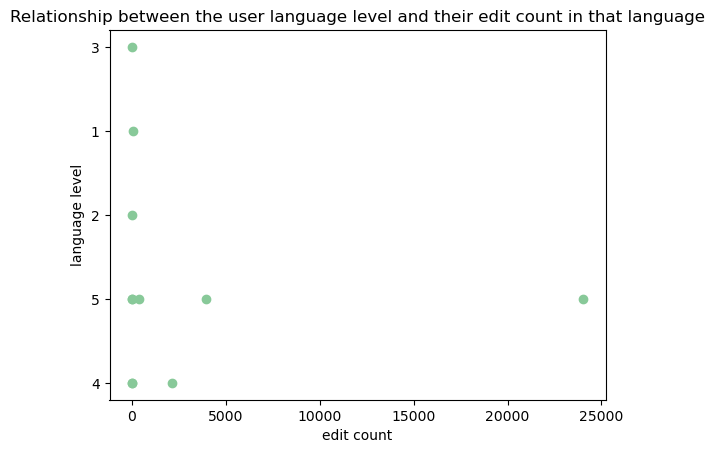

In [41]:
plt.scatter(df_users['edit_count'], df_users['level'], color = '#88c999')

plt.title("Relationship between the user language level and their edit count in that language")
plt.xlabel("edit count")
plt.ylabel("language level")
plt.show()

__Observations:__ []